<a href="https://colab.research.google.com/github/hrbae/LG_AI_training/blob/main/M1_Proces_Innovationby_ML/Practice/Practice_1_2_AutoPM_Event_Log_auto_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

from google.colab import drive

In [ ]:
drive.mount('/content/gdriv')

Mounted at /content/gdriv


In [ ]:
log = pd.read_csv('/content/gdriv/My Drive/lg실습/data/log.csv')
print(log.columns)

Index(['CONTAINER_NO', 'VESSEL', 'MCHN_ID', 'MCHN_TP_CD', 'JOB_TYPE',
       'FULL_EMPTY', 'BLOCK_BAY', 'JOB_END_DT'],
      dtype='object')


AutoPM: 프로세스 마이닝 수행과정 중 일부를 자동화하여 사용자에게 편리함을 제공하기 위한 방법


---


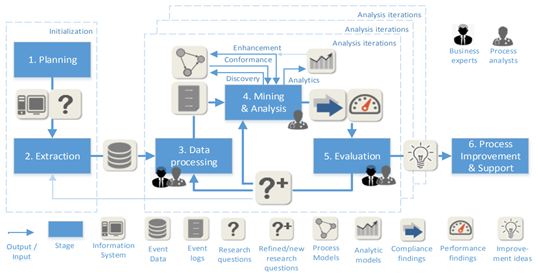

*   위의 그림은 프로세스 마이닝의 수행 절차로써 보여주는 그림으로써, 이벤트 데이터를 맵핑하는 과정으로 부터 시작
*   이벤트 데이터 맵핑 과정은 프로세스 마이닝에 대한 이해와 도메인에 대한 이해 모두 필요
*   아래의 그림은 앞서 수행한 이벤트 데이터 맵핑에 대한 수행 절차로써, 딥러닝을 통해 해당 절차를 자동화 할 수 있음




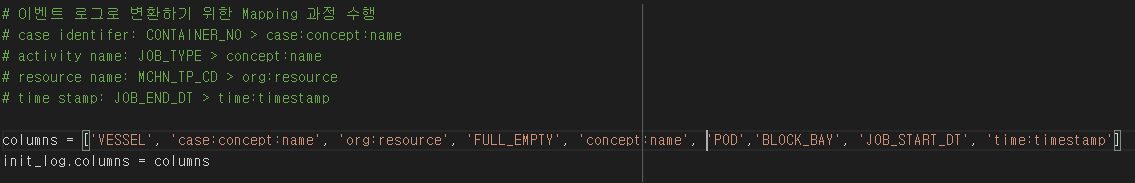



*   이벤트 데이터의 구조 및 이벤트 데이터 자동 맵핑
------

*   이벤트 데이터는 프로세스 부터 이를 구성하는 이벤트까지 계층적인 구조를 가짐
*   개별 이벤트 내에 포함된 속성들 간에는 종속성을 가짐
*   이러한 특징을 이용하여 이벤트 속성간의 관계를 matrix 혹은 이미지로 표현가능








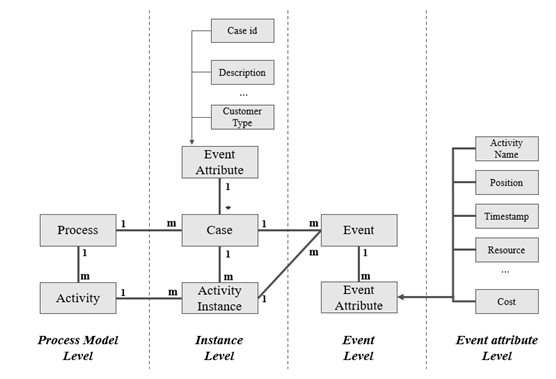

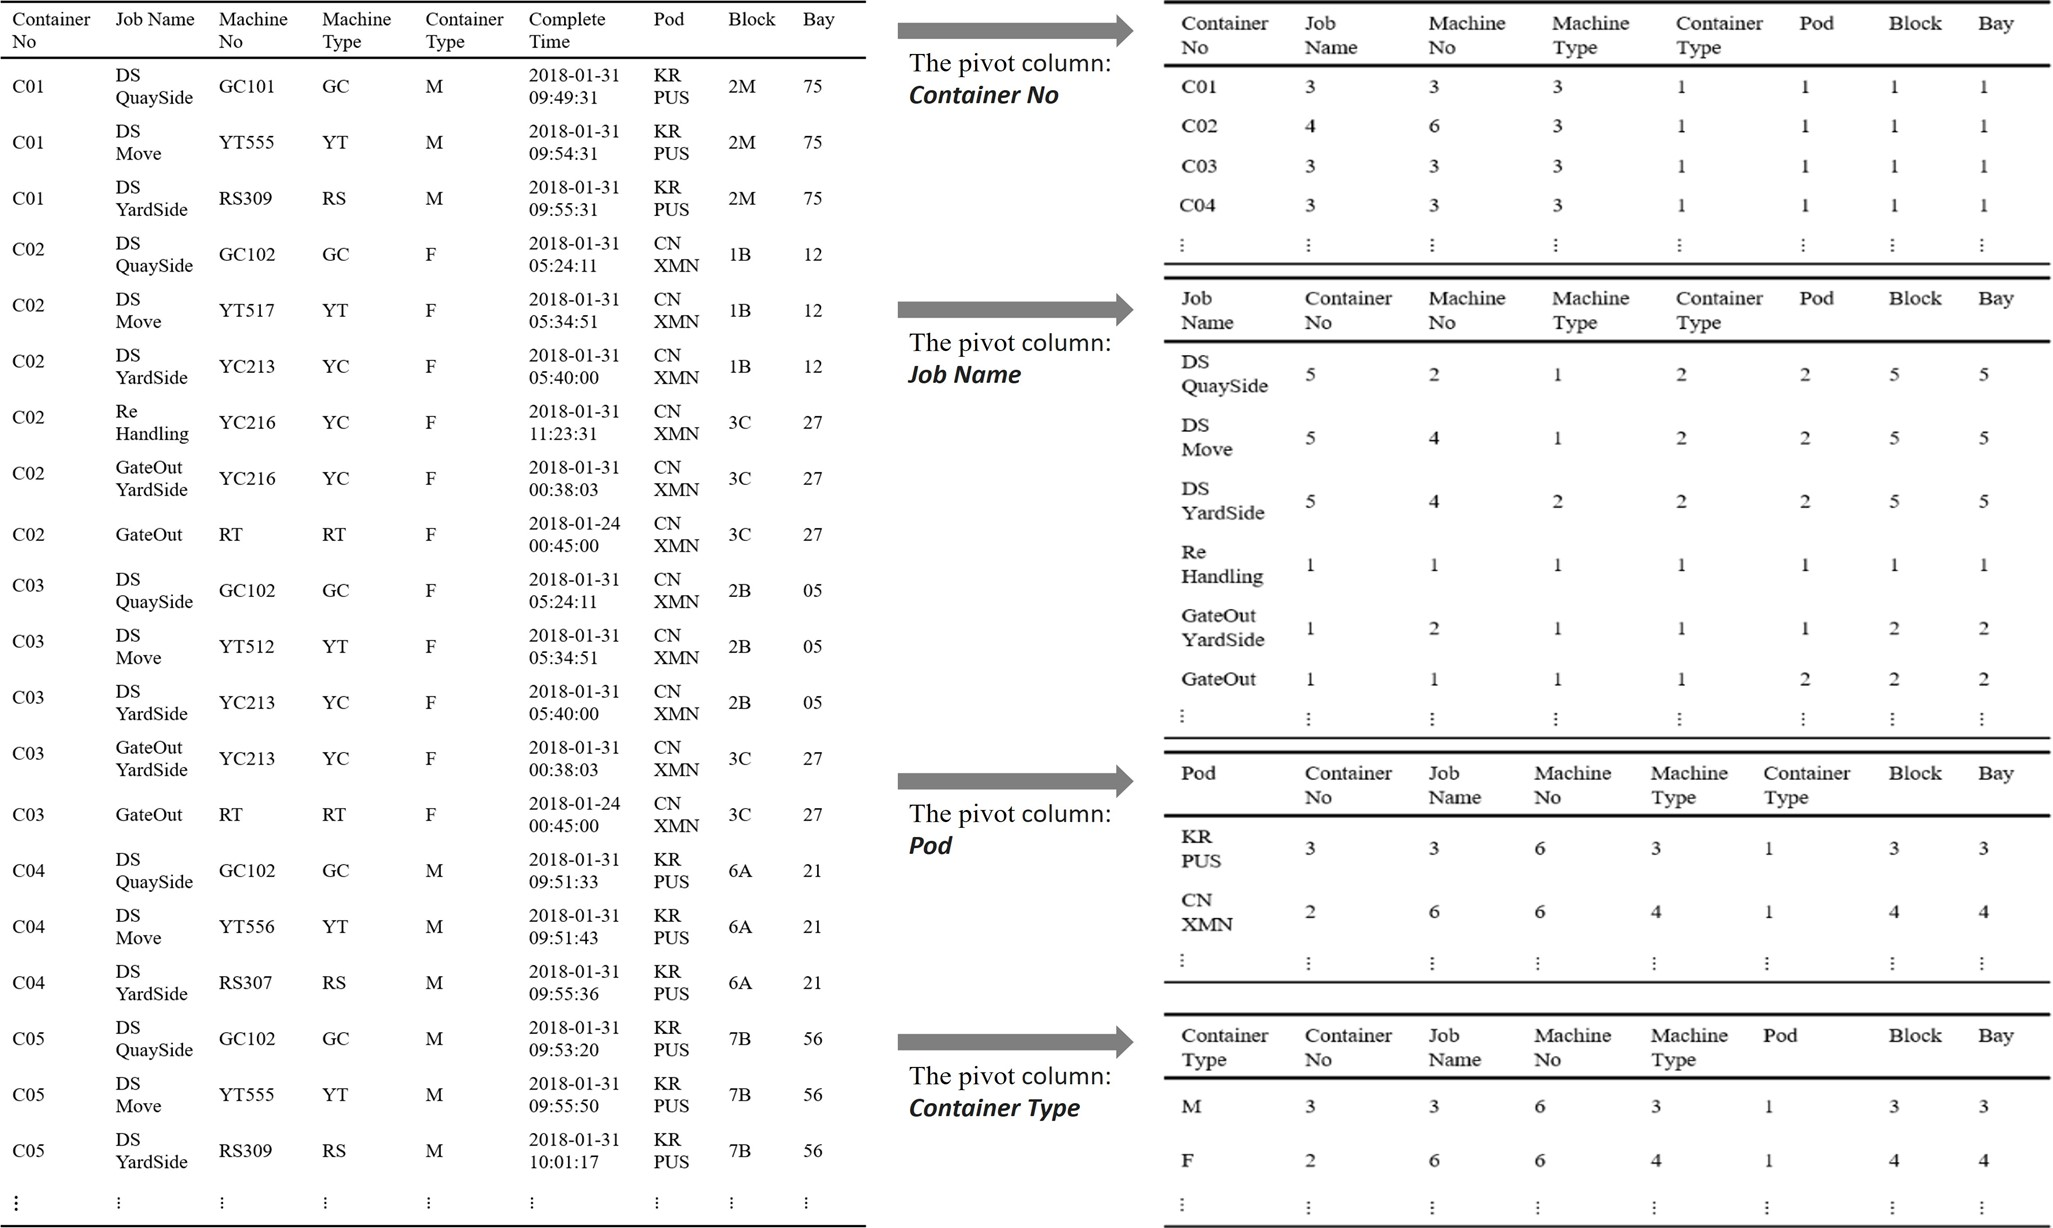

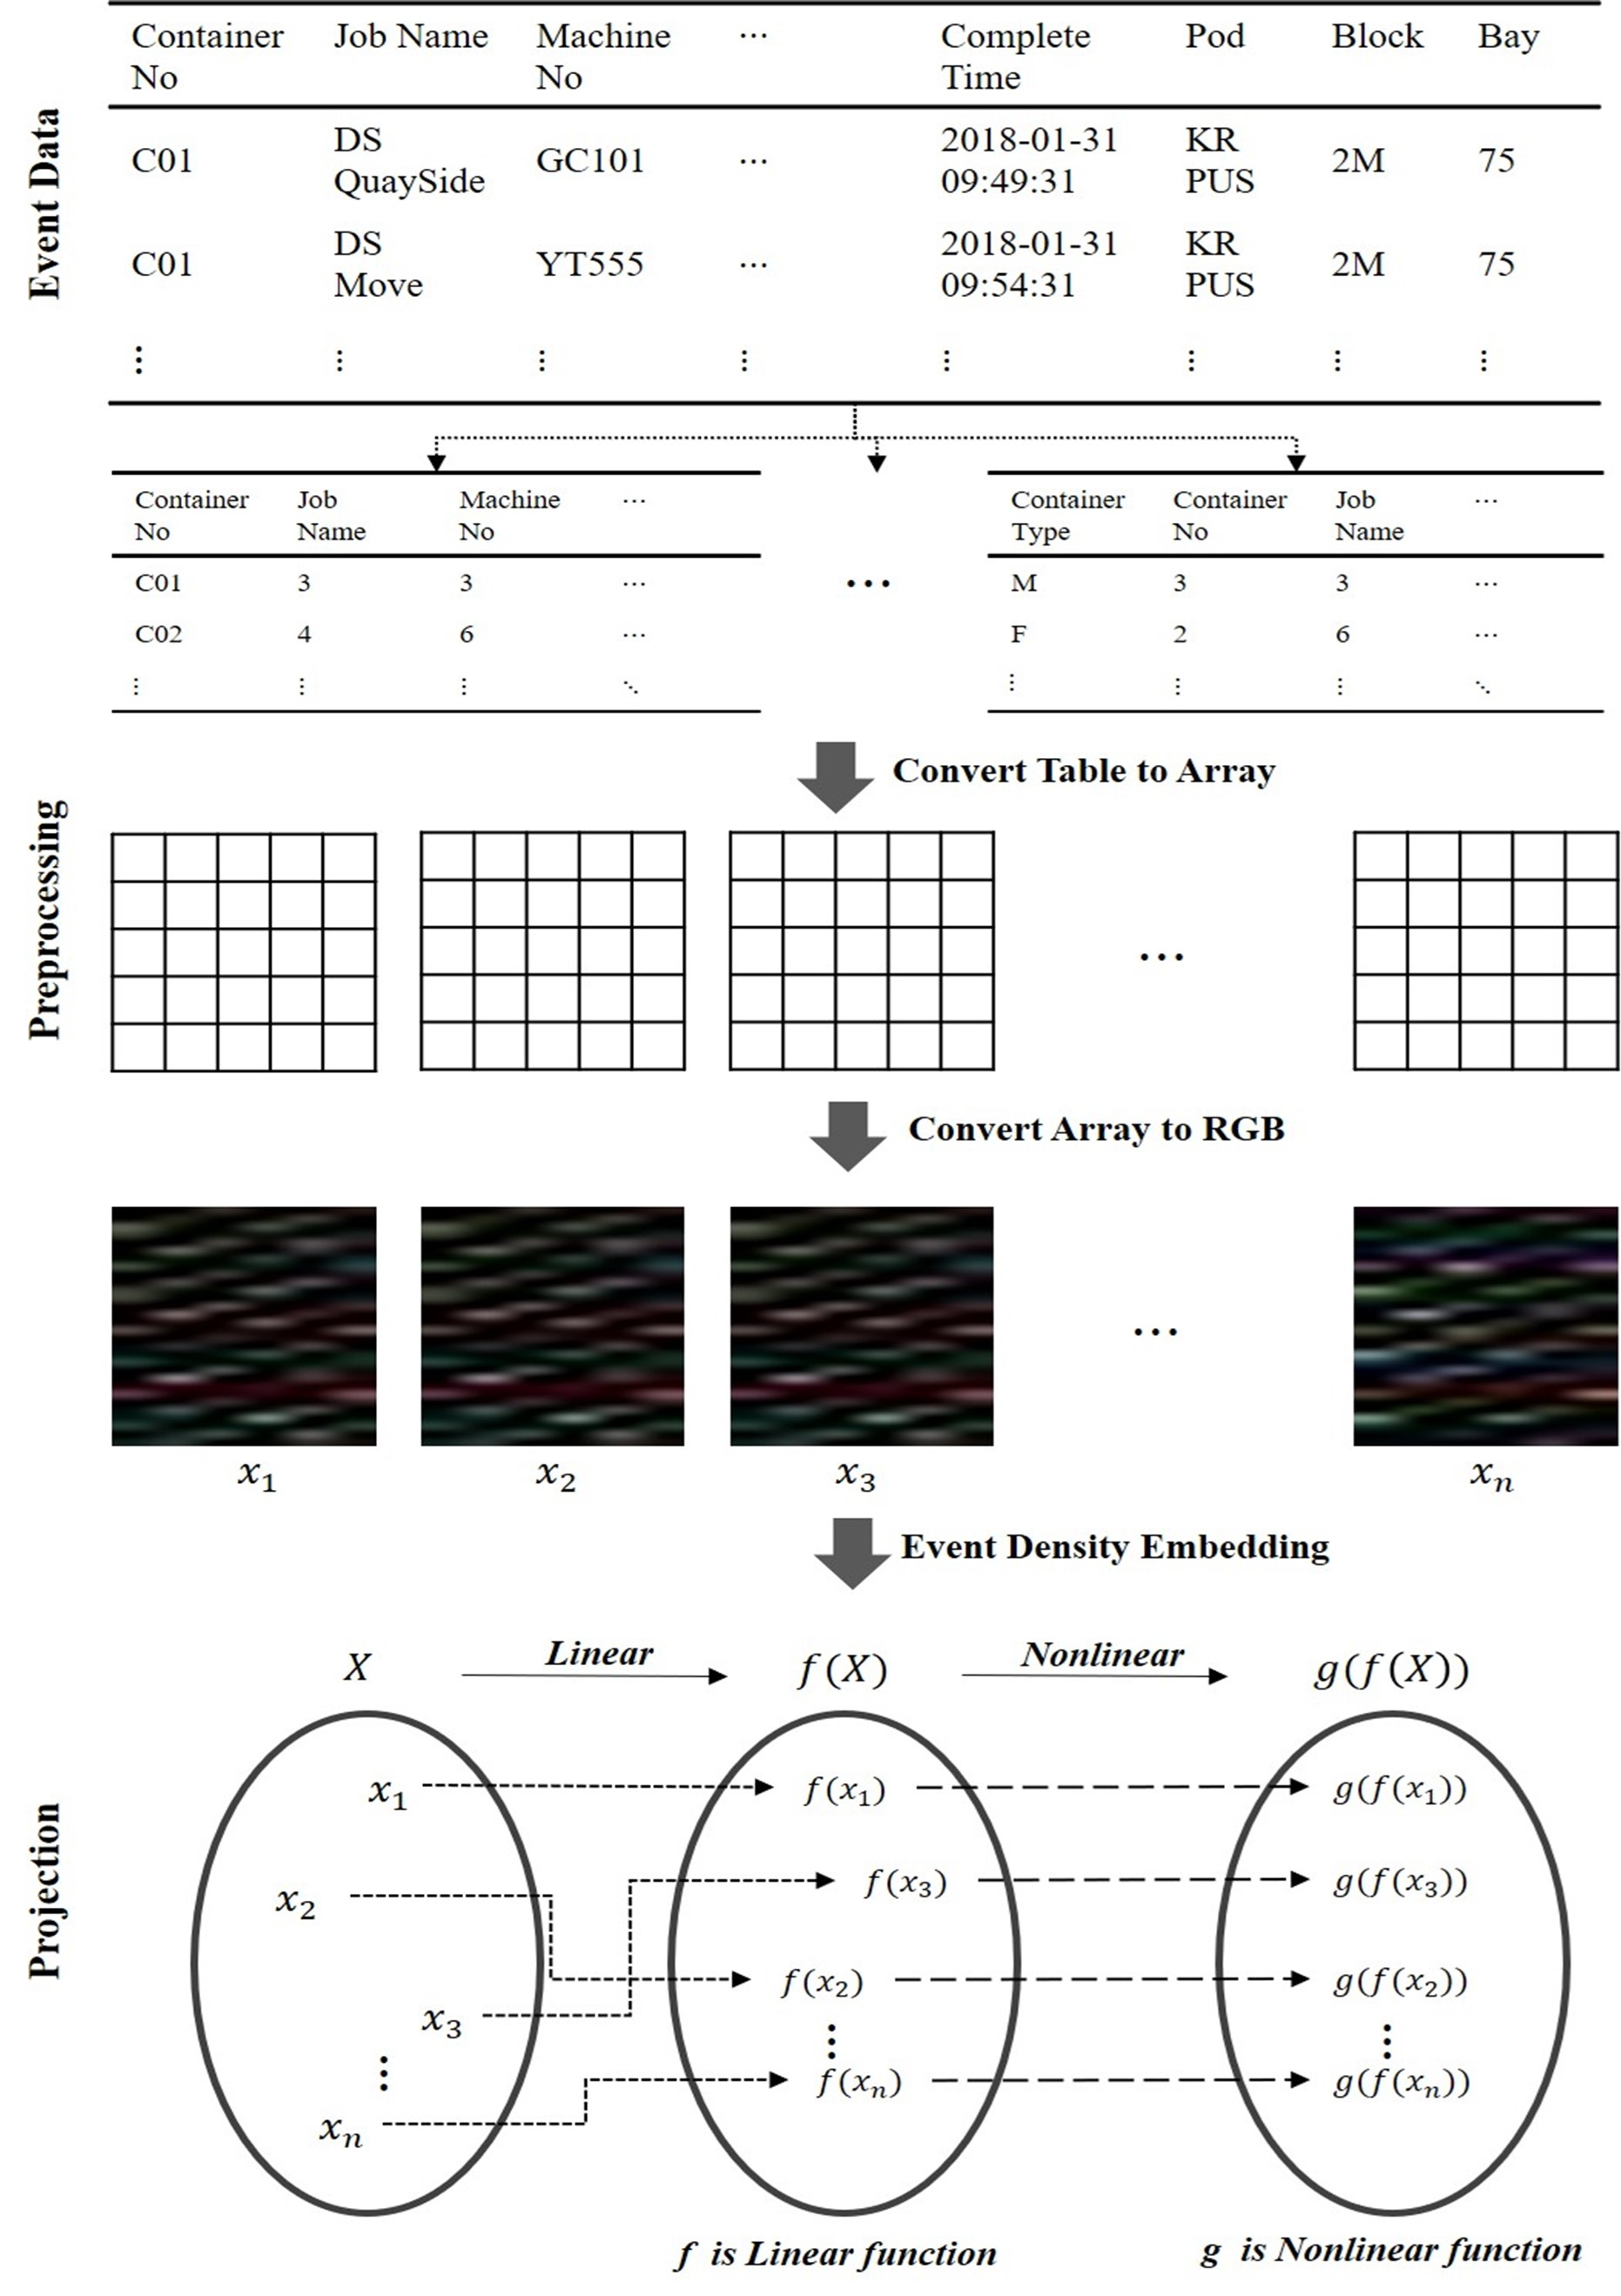

In [ ]:
# 학습에 사용할 mapping label setup
column = ['CONTAINER_NO', 'VESSEL', 'MCHN_ID', 'MCHN_TP_CD', 'JOB_TYPE', 'FULL_EMPTY', 'BLOCK_BAY']
label = ['caseid','attribute','resource', 'attribute', 'activity', 'attribute', 'attribute']

In [ ]:
# 학습 및 검증을 위한 데이터 생성 함수
class _ImageGenerator:    
    def __init__(self, log, column, label, numOfImage, numOfSample, ratio):
        
        self.log = log
        self.column = column
        self.label = label
        self.MatchingLabels = dict()
        
        for i in range(len(column)):
            self.MatchingLabels.update({column[i]:label[i]})
        
        self.NumOfImage = numOfImage
        self.NumOfSample = numOfSample
        self.SeperateRatio = ratio
    
    def _generateImage(self, mode):
        
        dt0 = self.log.loc[:,self.column]
        dt0 = dt0.fillna(99)
        NumOfTrain = round(self.NumOfImage*self.SeperateRatio)
        Label = pd.DataFrame(self.label)[0].value_counts()
        NumOfAttributes = Label['attribute']
        Label = {0:'caseid',1:'activity',2:'resource',3:'attribute'}

        AttRelationMatrix = list()
        
        for i in range(len(self.column)):
            
            print('Variable is',self.column[i],': Start')
            iter0 = 0

            if self.MatchingLabels[self.column[i]]=='attribute':
                
                while(iter0!=round(self.NumOfImage/NumOfAttributes)):

                    Case = self.log[self.column[i]].sort_values().drop_duplicates()
                    Case = Case.reset_index(drop=True)
                
                    if(len(Case)>self.NumOfSample):
                        
                        SampleNumber = np.random.randint(0,len(Case),self.NumOfSample)
                        SampleCase0 = Case.iloc[SampleNumber]
                    
                    else:
                    
                        SampleCase0 = Case
                    
                    SampleCase0 = SampleCase0.reset_index(drop = True)
                    Log0 = list()
                    label0 = self.column.copy()
                    
                    del label0[i]
                    
                    for j in range(len(SampleCase0)):
                        Log0.append(dt0.loc[dt0[self.column[i]]==SampleCase0[j],label0])
                     
                    RelationMatrix = np.zeros([len(SampleCase0),len(label0)])
                    
                    for n in range(len(SampleCase0)):
                        
                        if(len(Log0[n])==0):
                          pass
                        
                        else:
                            for k in range(len(label0)):
                              RelationMatrix[n,k] = Log0[n][label0[k]].value_counts().values[0]
                        
                    x = np.sort(RelationMatrix)
                    AttRelationMatrix.append(x)
                    iter0 += 1
                                    
            else:
                        
                while (iter0!=self.NumOfImage):
                
                    Case = self.log[self.column[i]].sort_values().drop_duplicates()
                    Case = Case.reset_index(drop=True)
                
                    if (len(Case)>self.NumOfSample):
                        
                        SampleNumber = np.random.randint(0,len(Case),self.NumOfSample)
                        SampleCase0 = Case.iloc[SampleNumber]
                    
                    else:
                        SampleCase0 = Case
                    
                    SampleCase0 = SampleCase0.reset_index(drop = True)
                    Log0 = list()
                    label0 = self.column.copy()
                    
                    del label0[i]
                    
                    for j in range(len(SampleCase0)):
                      Log0.append(dt0.loc[dt0[self.column[i]]==SampleCase0[j],label0])
                     
                    RelationMatrix = np.zeros([len(SampleCase0),len(label0)])
                    
                    for n in range(len(SampleCase0)):
                        
                        if (len(Log0[n])==0):
                          pass
                        
                        else:
                          for k in range(len(label0)):
                            RelationMatrix[n,k] = Log0[n][label0[k]].value_counts().values[0]
                        
                    x = np.sort(RelationMatrix)

                    if (mode == 'train'):
                        img = Image.fromarray(x, 'RGB')
                        img.save('/content/gdriv/My Drive/lg실습/image/train/' + self.MatchingLabels[self.column[i]] + '/' + str(iter0)+'.jpg')
                        
                    else:
                        img = Image.fromarray(x, 'RGB')
                        img.save('/content/gdriv/My Drive/lg실습/image/test/' + self.MatchingLabels[self.column[i]] + '/' + str(iter0-NumOfTrain)+'.jpg')
                        
                    iter0 += 1
                    
            print('Variable is',self.column[i],': Finish')
                
        np.random.shuffle(AttRelationMatrix)
        if mode == 'train':

          for i in range(NumOfTrain):
          
              x = AttRelationMatrix[i]
              img = Image.fromarray(x, 'RGB')
              img.save('/content/gdriv/My Drive/lg실습/image/train/attribute/'+ str(i)+'.jpg')
        else:
          
          for i in range(NumOfTrain, self.NumOfImage):
              
              x = AttRelationMatrix[i]
              img = Image.fromarray(x, 'RGB')
              img.save('/content/gdriv/My Drive/lg실습/image/test/attribute/'+ str(i-NumOfTrain)+'.jpg')
            
        print('생성된 이미지 데이터 저장 위치는 {}입니다'.format('[/content/gdriv/My Drive/lg실습/image]'))

In [ ]:
caseid = list(log['CONTAINER_NO'].value_counts().index)
np.random.shuffle(caseid)

idx = int(len(caseid)*0.7)
train_idx = caseid[:idx]
test_idx = caseid[idx:]

train_log = []
for idx in train_idx:
  train_log.append(log.loc[log['CONTAINER_NO']==idx,:])

train_log0  = train_log[0]
for i in range(len(train_log)):
  train_log0 = train_log0.append(train_log[i])

test_log = []
for idx in test_idx:
  test_log.append(log.loc[log['CONTAINER_NO']==idx,:])

test_log0  = test_log[0]
for i in range(len(test_log)):
  train_log0 = test_log0.append(test_log[i])

In [ ]:
train_log0 = train_log0.reset_index(drop=True)
test_log0 = test_log0.reset_index(drop=True)

In [ ]:
x = _ImageGenerator(log, column, label, 100, 5, 0.7)
x._generateImage(mode = 'train')
x._generateImage(mode = 'test')

Variable is CONTAINER_NO : Start
Variable is CONTAINER_NO : Finish
Variable is VESSEL : Start
Variable is VESSEL : Finish
Variable is MCHN_ID : Start
Variable is MCHN_ID : Finish
Variable is MCHN_TP_CD : Start
Variable is MCHN_TP_CD : Finish
Variable is JOB_TYPE : Start
Variable is JOB_TYPE : Finish
Variable is FULL_EMPTY : Start
Variable is FULL_EMPTY : Finish
Variable is BLOCK_BAY : Start
Variable is BLOCK_BAY : Finish
생성된 이미지 데이터 저장 위치는 [/content/gdriv/My Drive/lg실습/image]입니다
Variable is CONTAINER_NO : Start
Variable is CONTAINER_NO : Finish
Variable is VESSEL : Start
Variable is VESSEL : Finish
Variable is MCHN_ID : Start
Variable is MCHN_ID : Finish
Variable is MCHN_TP_CD : Start
Variable is MCHN_TP_CD : Finish
Variable is JOB_TYPE : Start
Variable is JOB_TYPE : Finish
Variable is FULL_EMPTY : Start
Variable is FULL_EMPTY : Finish
Variable is BLOCK_BAY : Start
Variable is BLOCK_BAY : Finish
생성된 이미지 데이터 저장 위치는 [/content/gdriv/My Drive/lg실습/image]입니다


In [ ]:
class _ImageLoader(Dataset):
    
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                
                if img is not None:
                    
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return {'image': image, 'label': self.labels[index]}

    def __len__(self):
        return self.length


*   학습을 위한 네트워크 구조
---


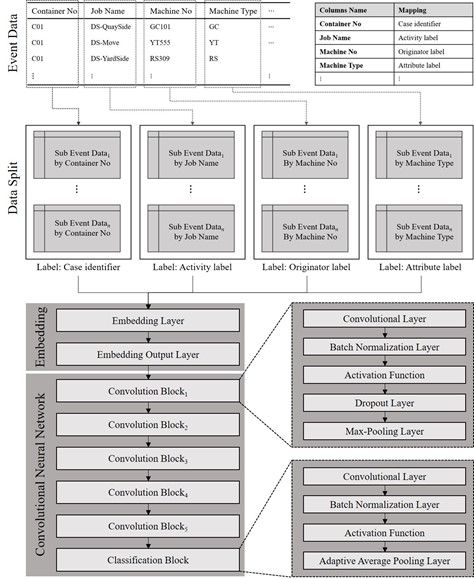

In [ ]:
class _AutoMapper(nn.Module):
    
    def __init__(self, NumOfclasses):
        
        super(_AutoMapper, self).__init__()
        
        self.NumOfclasses = NumOfclasses
        self.layer1 = self.conv_module(3, 16)
        self.layer2 = self.conv_module(16, 32)
        self.gap = self.global_avg_pool(32, NumOfclasses)

    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.gap(out)
        out = out.view(-1, self.NumOfclasses)
        return out

    def conv_module(self, in_num, out_num):
        
        return nn.Sequential(
                nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_num),
                nn.ELU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
                )

    def global_avg_pool(self, in_num, out_num):
        
        return nn.Sequential(
                nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_num),
                nn.ELU(),
                nn.AdaptiveAvgPool2d((1, 1))
                )

In [ ]:
transformer_train = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.RandomRotation(10,),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])])

transformer_test = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])])

trainDataSet = _ImageLoader(data_set_path=('/content/gdriv/My Drive/lg실습/image/train'), transforms = transformer_train)
testDataSet = _ImageLoader(data_set_path=('/content/gdriv/My Drive/lg실습/image/test'), transforms = transformer_test)

trainLoader = DataLoader(trainDataSet, batch_size=16, shuffle=True)
testLoader = DataLoader(testDataSet, batch_size=16, shuffle=True)

In [ ]:
model = _AutoMapper(NumOfclasses = 4).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
for e in range(10):
    train_loss = []
    for idx, item in enumerate(trainLoader):
        
        images = item['image'].cuda()
        labels = item['label'].cuda()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    #if (e+1) % 10 == 0:
    acc = 0
    total = 0
    with torch.no_grad():
        for item in testLoader:
          image = item['image'].cuda()
          labels = item['label']

          out = model(image)
          pred = torch.argmax(out, axis=1)
          acc += torch.sum(pred.cpu() == labels).numpy()
          total += len(labels)
    print('[Epoch: {}/{}], [Train Loss: {}] [Test Acc: {}]'.format(e+1, 10, str(np.mean(train_loss))[:8], str(acc/total*100)[:8]))

[Epoch: 1/100], [Train Loss: 0.544165] [Test Acc: 91.81818]
[Epoch: 2/100], [Train Loss: 0.218181] [Test Acc: 95.81818]
[Epoch: 3/100], [Train Loss: 0.164115] [Test Acc: 92.36363]
[Epoch: 4/100], [Train Loss: 0.137321] [Test Acc: 94.48484]
[Epoch: 5/100], [Train Loss: 0.126537] [Test Acc: 97.87878]
[Epoch: 6/100], [Train Loss: 0.092060] [Test Acc: 97.39393]
[Epoch: 7/100], [Train Loss: 0.095861] [Test Acc: 97.81818]
[Epoch: 8/100], [Train Loss: 0.065013] [Test Acc: 98.90909]
[Epoch: 9/100], [Train Loss: 0.058847] [Test Acc: 98.18181]
[Epoch: 10/100], [Train Loss: 0.097362] [Test Acc: 97.21212]
[Epoch: 11/100], [Train Loss: 0.063790] [Test Acc: 98.84848]
[Epoch: 12/100], [Train Loss: 0.055915] [Test Acc: 98.60606]


KeyboardInterrupt: ignored